Overview

At the beginning of the project, we give a rough overview of the analysis and how the project is structured. 
This should make it easier for the reader to follow the code and understand our results.

1. Editing the data set and feature engineering
Before we start with the first task, we look at the object features. They cannot easily be used for the ML analysis, but they contain a lot of information, which makes them a valuable feature.
In all data sets there were the following three object features: title, artist and genre. We tried to use them as explained in the following:
       
    a. top genre: In order to be able to better use the information provided by the genres, we grouped them into six clusters using k-means.

    b. artist: To make better use of this variable, we added a dataset containing all Grammy award winners proxying for the popularity of the artist.    

    c. title: Here we tried to evaluate the sentiment of titles using NLP analysis and let this be part of the analysis. Since these results were not significant, we decided to discard them.
    

2. Data exploration and identification of significant variables
For this purpose, a correlation matrix of the features is used and the spread of the residuals is analysed 
and interpreted. We investigated feature importance using pca and random forrest.
A detailed explaination of the varibale selection is given in the sections.

3. Regression model
Using the selected variables we tried different regression techniques trying to further improve them by using ensamble learning and hyperparameter tuning. We have found descission trees to be particularly effective and submitted the model to the kaggle challenge generating a score 7.31 (group-name: Help).

4. Classification
Since the data set of classification is the same as that of the regression problem, we simply used 
the already eddited data sets from above and adjusted it a bit, while using the new added features. 
The procedure for Classifying is basically the same as for Regression. 
Using the selected variables we tried different classification techniques trying to improve them by using ensamble learning and hyperparameter tuning. We have found random forest to be particularly effective and submitted the model to the kaggle challenge generating a score 0.32 (group-name: Help). 
In addition, an attempt is made to carry out a prediction with fewer outliers. Further, we duplicated outliers in the dataset for a better result. Both strategies did not improve the accuracy. 

In [2]:
#standard libaries
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt    
import json
from numpy.random import seed
from numpy.random import randn
import random
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats
# Standard ML Models for comparison
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.cluster import KMeans
!pip install xgboost
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score,recall_score,precision_score,f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn import metrics
#Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# Metrics & graphs
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from IPython.core.pylabtools import figsize
# Distributions
import scipy
#NLP
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
!pip install textblob
from textblob import TextBlob
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jom20\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data and preparing Dataset


In [3]:
train = pd.read_csv("CS98XRegressionTrain.csv")
test = pd.read_csv("CS98XRegressionTest.csv")

#laoding grammy winner dataset - grammy award winners are assumed to be successfull and due to this popular among listerns on spotify
#source: https://www.kaggle.com/unanimad/grammy-awards
grammy = pd.read_csv("the_grammy_awards.csv")

#correct data
train.iloc[17,2] = "Celine Dion"
test.iloc[66,3]='pop'
#combine train & test for clustering
frames = [train, test]
train_test = pd.concat(frames)
train_test.dropna(subset=['top genre'], inplace=True)

Looking at the data, we have three columns (artist, genre, title), which are objects. To get the most insights into this data, we use different strategies to convert these into numerical values so that our used ML algorithms can be trained on the largest set of features possible. We have tried to convert Genres in two ways. First, we have web scrapped data from https://www.musicgenreslist.com/, which let us build a dictionary of eight main genres containing around 600 subgenres. Main genres were further transferred into dummy variables. The drawback of this method was that the categorization was mostly subjective and led to lower performance. Therefore, we have used clustering (k-means) to mimic genres based on genre specfic features (bpm', 'nrgy','dnce', 'dB','live', 'val', 'dur', 'acous' ,'spch) of the songs and converted them to dummy variables. Titles have been transformed using NLP following the reasoning that more positive or negative song titles are associated with more intense feelings, which might be more memorizable and leads to higher popularity. Drawback of this method is that it tends to be a bit radom in this case, that is why we have not used it finally.
Artists contain a lot of information in general as the likelihood of successful artists publishing new popular songs is higher than vice-versa. To proxy success, we have merged the given dataset with a database of grammy award winners from 1958-2019 (https://www.kaggle.com/unanimad/grammy-awards).

## Clustering Data with unsupervised learning

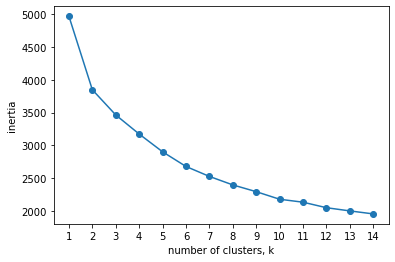

In [4]:
#cluster k-means
ks = range(1, 15)
inertias = []
train_test_clustering = train_test[['bpm', 'nrgy','dnce', 'dB','live', 'val', 'dur', 'acous' ,'spch']]
train_test_clustering = train_test_clustering.values
std_scaler = StandardScaler()
scaled_cluster = std_scaler.fit_transform(train_test_clustering)
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(scaled_cluster)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)   
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [5]:
#6 Clusters according to graph above using k-Means
model = KMeans(n_clusters=6)
labels = model.fit_predict(scaled_cluster)
train_test['labels'] = labels #labelling the data
train_test['labels']= train_test['labels'].map({0:'cluster0', 1:'cluster1', 2:'cluster2', 3:'cluster3', 4:'cluster4', 5:'cluster5'})

## Adding Grammy information

In [6]:
#Adding success column for grammy winners
grammy["artist"].dropna()
winners = grammy["artist"].unique()
winners = list(winners)
winners.append("TOTO")
winners.append("Queen")
winners.append("Bryan Adams")
winners.append("Bon Jovi")
winners.append("50 Cent")
winners.append("John Lennon")
conditions = [
    train_test['artist'].isin(winners)]
choices = [1]
train_test['success'] = np.select(conditions, choices, default= 0)

## Creating the original train and test Datasets

In [7]:
train_test = train_test.drop(['title', 'top genre', 'artist'] ,axis=1)
train_test = pd.get_dummies(train_test)
train_test = train_test.drop(['labels_cluster5' ], axis=1)
#splitting into train and test data
train_start = pd.DataFrame(train_test[:438])
test_start = pd.DataFrame(train_test[438:])

# Exploring Data

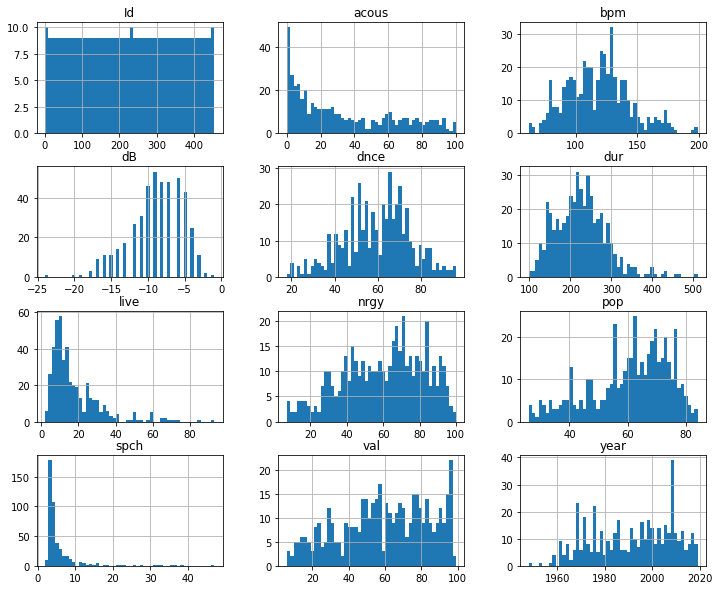

In [203]:
train.hist(bins=50, figsize=(12,10))
plt.show()

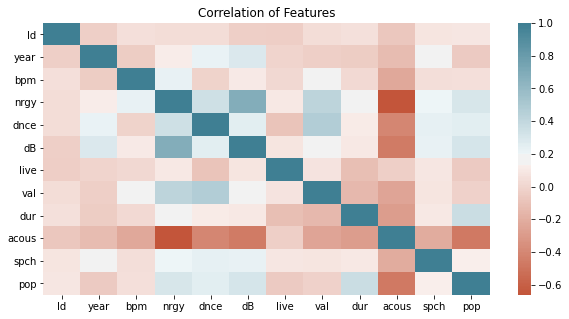

In [8]:
corr = train.corr()
plt.subplots(figsize=(10,5))
sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200))
plt.title('Correlation of Features')
plt.show()

# Regression

## Data Exploration for Regression

success is a good new feature as it has a low correlation with the other features and therefore brings further information (cor. to pop 0.3-0.4). 
In general, it is complicated to spot valuable relationships using scatterplots and analysing the correlation to leverage on in this dataset given the many outliers. 

Moreover, we could not spot any shapes that would have been benefitted from transformations (e.g. squaring). 

Variable nrgy and dB seemed to be higher correlated given the heatmap, and regarding the scatterplot, it is clear that both follow a linear trend. Based on this, we have combined them into one variable, performing poor on the training set later on for the regression and classification part. 

nrgy has a considerably negative corelation with pop (~ -0.6), nevertheless looking at the scatterplot, there was no clear relationship to spot. 

Bpm was dropped as the correlation of the variable with pop is close to zero (for regression). Further, the scatterplot has not shown any significant relationship, which might be detected by the ML algorithms used. 

acous and nrgy have a high negative corr; we could not detect any meaningful relationship in the scatterplot. 

The declarative value of the variable spch is very low, as most of the values are between 3 and 5 and evenly distributed among popularity. Therefore, ML cannot detect any characteristics. live follow a similar pattern. 

dur follows a slight u-shaped pattern plotted against pop. dur is most popular between 200-300. We have tried to transform it while squaring it, which was not performing well in our ML algorithms. Next, we have converted it into a dummy-variable, which takes into consderation the preferable length of the song (1) vs length before and after that (0). This was not performing well and, therefore, not considered. 

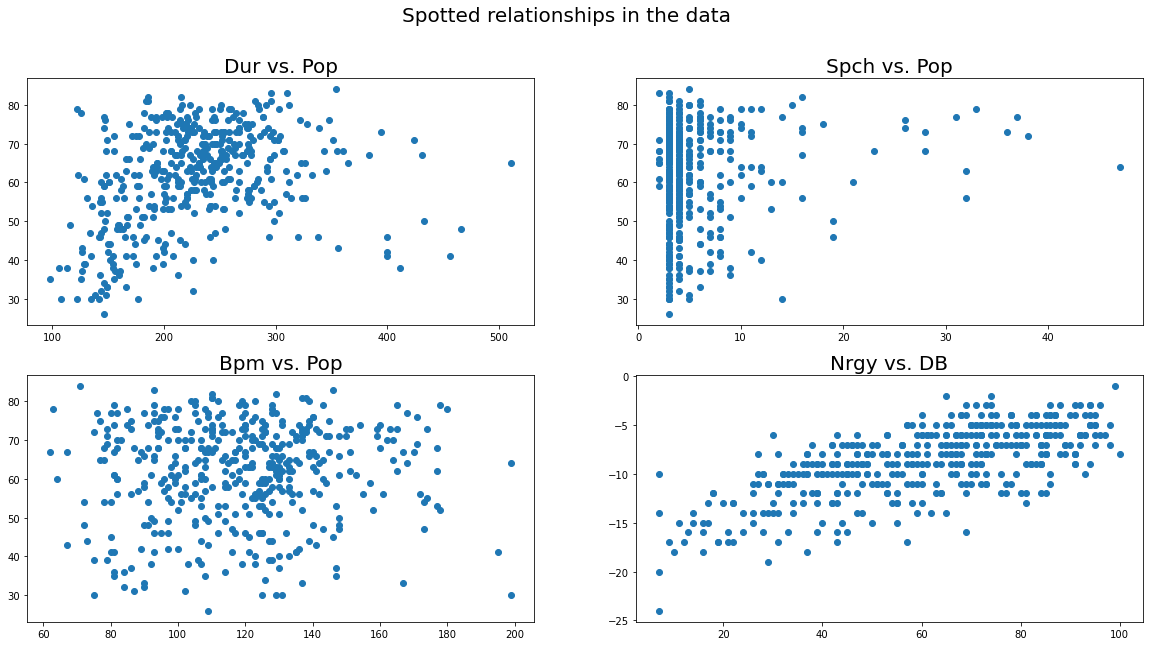

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Spotted relationships in the data', size=20)
ax[0,0].scatter(x="dur", y="pop", data=train_start)
ax[0,1].scatter(x="spch", y="pop", data=train_start)
ax[1,0].scatter(x="bpm", y="pop", data=train_start)
ax[1,1].scatter(x="nrgy", y="dB", data=train_start)
ax[0,0].set_title("Dur vs. Pop", size=20)
ax[0,1].set_title("Spch vs. Pop", size=20)
ax[1,0].set_title("Bpm vs. Pop", size=20)
ax[1,1].set_title("Nrgy vs. DB", size=20)
plt.show()

## Feature importance

To choose between the given features, we generate the feature importance using Pca and random forest. The models are used on the given training data, which is further split into train/test data and scaled (scaling tend to improve the models).
Based on our feature importance and the model performance, we have taken out variable dur. Further, we have a first glance at our feature selection's performance using linear regression evaluating it with RMSE.

In [10]:
#preparing test-train split
random.seed(72)
#scaling
y = train_start['pop'].values
std_scaler = StandardScaler()
X_cluster = train_start.drop(['pop', 'Id','bpm','live','dur','spch'], axis=1).values
X_scaled_cluster = std_scaler.fit_transform(X_cluster)
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_scaled_cluster, y, test_size=0.2, random_state=42)

X_clean = train_start.drop(['pop', 'Id','bpm','spch','labels_cluster0','labels_cluster1','labels_cluster2','labels_cluster3','labels_cluster4'], axis=1).values
X_scaled_clean = std_scaler.fit_transform(X_clean)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_scaled_clean, y, test_size=0.2, random_state=42)

#test dataset
X_cluster_test = test_start.drop(['pop','Id','bpm','live','dur','spch'], axis=1).values
X_scaled_cluster_test = std_scaler.fit_transform(X_cluster_test)

X_clean_test = test_start.drop(['pop','Id','bpm','spch','labels_cluster0','labels_cluster1','labels_cluster2','labels_cluster3','labels_cluster4'], axis=1).values
X_scaled_clean_test = std_scaler.fit_transform(X_clean_test)

Regres = LinearRegression()
Regres.fit(X_train_cluster,y_train_cluster)
y_predict = Regres.predict(X_test_cluster)
#initial train test split of linear regression only looking at the 
#yields an RMSE score of 10.36. this does not consider the actual test dataset as provided
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_cluster, y_predict)))

Root Mean Squared Error: 9.038745385503956


In [11]:
#Checking the feature importance of different combinations of variables using random forest
#example: Final model feature importance after reducing it with uncessary variables

from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, 
                      max_leaf_nodes=50, n_jobs=-1)

rnd_clf.fit(X_train_cluster, y_train_cluster)
y_pred_rf = rnd_clf.predict(X_test_cluster)
for name, score in zip(train_start.drop(['pop', 'Id','bpm','live','dur','spch'], axis=1).keys(), rnd_clf.feature_importances_):
    print(name, score)

year 0.15558993543360913
nrgy 0.15315064274066587
dnce 0.14959569515053958
dB 0.11444599142585095
val 0.1555416251623187
acous 0.1555893077226977
success 0.03577858399716244
labels_cluster0 0.021835050829115826
labels_cluster1 0.011156868852838338
labels_cluster2 0.022101970685331453
labels_cluster3 0.01800099169606018
labels_cluster4 0.00721333630380997


In [12]:
#Checking the feature importance of different combinations of variables using PCA
#example: Final model feature importance after reducing it with uncessary variables
pca = PCA()
pca.fit(X_train_cluster)
for name, score in zip(train_start.drop(['pop', 'Id','bpm','live','dur','spch'], axis=1).keys(), pca.explained_variance_ratio_):
    print(name, score)

year 0.30008717659791573
nrgy 0.1365338588631166
dnce 0.1107642165895167
dB 0.09530507319344354
val 0.08814227773193394
acous 0.07781293887211051
success 0.06409900082796484
labels_cluster0 0.04352978226559001
labels_cluster1 0.033755378380549664
labels_cluster2 0.01948010322898833
labels_cluster3 0.017766153728006242
labels_cluster4 0.012724039720863887


Both feature selection tend to perform similar, normally we should perfer the model with less features according to Okams'
razor. Further, the variable importance of the cluster dummy varibales are also considerably low given the following
feature importance analysis. However, we continue with both options.

## Evaluate the final Regression models


We have built a function to evaluate several ML models by training on the splitted training data. 

Therefore, the function loops over several ML methods beeing: Linear Regression, ElasticNet Regression, Random Forest, Extra Trees, SVM, Decisiontree, Boosting (AdaBoost, GradientBoost, XGBRegressor), Voting Regressor.

In [13]:
#Building a function to evaluate several ML models by training on the splitted training data 
def evaluate(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Decisiontree' ,'AdaBoost','XGBRegressor','Voting Regressor','Baseline']
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=1000)
    model4 = ExtraTreesRegressor(n_estimators=1000)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    model7 = DecisionTreeRegressor(random_state=0)
    model8 = AdaBoostRegressor(random_state=0, n_estimators=100)
    model10 = xgb.XGBRegressor(objective='reg:linear',n_estimators=10, seed=123)
    model11 = VotingRegressor([('Linear Regression', model1), ('ElasticNet Regression', model2), ('Random Forest', model3), ('SVM', model5), ('Gradient Boosted' ,model6)])    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)   
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6, model7,model8,model10,model11]):
        model.fit(X_train_cluster, y_train_cluster)
        predictions = model.predict(X_test_cluster)      
        # Metrics
        mae = np.mean(abs(predictions - y_test_cluster))
        rmse = np.sqrt(np.mean((predictions - y_test_cluster) ** 2))      
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]  
    # Median Value Baseline Metrics
    baseline = np.median(y_train_cluster)
    baseline_mae = np.mean(abs(baseline - y_test_cluster))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test_cluster) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [14]:
results_withcluster = evaluate(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster)
results_withcluster
#Random Forest performs best on the training set test part given the used feature selection with RMSE around 8.2

[23:45:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,mae,rmse
Linear Regression,7.26236,9.03875
ElasticNet Regression,8.0437,9.63849
Random Forest,6.5533,8.32023
Extra Trees,6.48451,8.27141
SVM,7.87074,9.82346
Gradient Boosted,6.97792,8.79795
Decisiontree,10.1705,12.94
AdaBoost,7.31437,8.91261
XGBRegressor,8.13816,10.0245
Voting Regressor,7.09069,8.74532


In [15]:
results_withoutcluster = evaluate(X_train_clean, X_test_clean, y_train_clean, y_test_clean)
results_withoutcluster
#Extra trees performs best on the training set test part given the used feature selection with RMSE around 8.0
#both ML algorithms perform pretty similiar with different feature selection/ engeneering

[23:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,mae,rmse
Linear Regression,7.32489,9.04528
ElasticNet Regression,8.13203,9.71652
Random Forest,6.57991,8.57934
Extra Trees,6.44475,8.05989
SVM,7.67696,9.57551
Gradient Boosted,6.84049,8.79013
Decisiontree,9.625,12.5268
AdaBoost,7.35795,9.31337
XGBRegressor,6.98383,8.87204
Voting Regressor,7.13559,8.8141


With and without clustering Random Forest and Extra Trees are the best prediction models. The good performance of tree models is due to the fact that those models are less influenced by outliers. As described above, our data set has many outliers. Another advantage is that they are very good at dealing with colinearity in the features, so the information gained by splitting on one of the features will also use the prediction power of the other feature. We think that these points are crucial for why trees are the best performing predictor of popularity. In addition, we tried using the models with PCA, however, the performance decreased.

## Hyperparameter Tuning

When submitting our best models to Kaggle we found out that Random Forest outperformed Extra trees. To increase our accuracy score we used RandomizedSearchCV to optimise our Hyperparameters.

In [16]:
RFReg = RandomForestRegressor(n_estimators = 500, max_depth=4, max_features='auto', random_state = 1, n_jobs = -1) 

param_grid = { 
    'n_estimators' : [x for x in range(100,1000,100)],
    'max_features' : ["auto", "sqrt", "log2"],
    'max_depth' : [x for x in range(1,20)]}

CV_rfc = RandomizedSearchCV(estimator=RFReg, param_distributions = param_grid, n_jobs = -1, cv= 10, n_iter = 100, random_state=15)
CV_rfc.fit(X_train_cluster, y_train_cluster)
print('Best Hyperparameters:',CV_rfc.best_params_)
print('Best Score:',CV_rfc.best_score_)

Best Hyperparameters: {'n_estimators': 400, 'max_features': 'log2', 'max_depth': 13}
Best Score: 0.27153715223641506


In [22]:
#fitting the best model based ont the Hyperparameters
model3 = RandomForestRegressor(n_estimators= 400, max_features= 'log2', max_depth= 13)
model3.fit(X_train_cluster, y_train_cluster)
predictions = model3.predict(X_test_cluster)      
print('MAE:', np.mean(abs(predictions - y_test_cluster)))
print('RMSE:', np.sqrt(np.mean((predictions - y_test_cluster) ** 2)))  

MAE: 6.192969583060946
RMSE: 7.865029478838098


Using Hyperparameter tuning, we could generate RMSE scores of below eight on our training data, which would be our best model. Nevertheless, the hyperparameters are overfitting to our training data and perform not as good as the more general model on the Kaggle challenge. Therefore, our final model is a Random Forest. We increase our training data on the train-test-split for submission and let the model learn on as many instances as possible before predicting the test data for the competition.

In [23]:
#Final Model generated for Kaggle (RMSE 7.31)
model3 = RandomForestRegressor(n_estimators= 1000)
model3.fit(X_train_cluster, y_train_cluster)
y_predict = model3.predict(X_scaled_cluster_test)
kaggle = pd.DataFrame()
kaggle['Id'] = test_start['Id']
kaggle['pop'] = y_predict
kaggle.to_csv('Rf_Regress_1000_Hyper.csv', index= False)

# Classification

In [24]:
#preparing the test data
pop_score_test = pd.read_csv("CS98XClassificationTest.csv")
test_classification = test_start.copy()
test_classification = test_classification.drop(test_classification.index[66])
test_classification.reset_index(drop=True, inplace=True)
test_classification['pop'] = pop_score_test['pop']
#preparing the train data
train_class = train.copy()
train_class.dropna(subset=['top genre'], inplace=True)
train_classification = train_start.copy()
train_classification['top genre'] = train_class['top genre']

#counts = train_classification['top genre'].value_counts()
#train_classification = train_classification[~train_classification['top genre'].isin(counts[counts < 10].index)]

### Exploring Data for the Classification

Based on the data exploration done in the first part we are using the K-means cluster. Nevertheless, any further derived information in the data exploration was not beneficial to our scores leading to a more iterative feature selection approach.

Since the data is heavily imbalanced with some genres appearing more frequent, we decided to remove the rows of genres that appear below a different thresholds and train the models with only the most common genres. Obviously, the accuracy of the models improved on the trainingset, but this was not reflected when we used our best model on Kaggle. 

As mentioned above, one of the key problems of our dataset is that it is imbalanced. This means that there are very few examples of some genres in order for the models to effectively learn to identify those classes. 
One possible way to solve that problem is to oversample the minority classes in the target by duplicating those examples in order to appear more frequent in the training dataset so that models can learn better.

One of the most widely used approaches is Synthetic Minority Oversampling technique (SMOTE). Using this method we achived to increase the accuracy in the training data. However, these was not reflected on Kaggle, while generating a very low accuracy score. One possible reason is that this technique may increase the overlapping of classes and so it increases the noise in the data.

In [25]:
train_classification['top genre'].value_counts()

adult standards       68
album rock            66
dance pop             61
glam rock             16
brill building pop    16
                      ..
belgian dance          1
afropop                1
hi-nrg                 1
classic girl group     1
glam punk              1
Name: top genre, Length: 86, dtype: int64

Based on trial error and according to the model performance we have taken out the variables year and success. Further, we have a first glance on the performance of our feature selection using Logistic regression evaluating it with the accuracy score.

In [26]:
random.seed(82)

y_class = train_classification['top genre'].values
std_scaler = StandardScaler() 
X_cluster_class = train_classification.drop(['top genre','Id','year','success'], axis=1).values
X_scaled_cluster_class = std_scaler.fit_transform(X_cluster_class)
X_train_cluster_class, X_test_cluster_class, y_train_cluster_class, y_test_cluster_class = train_test_split(X_cluster_class, y_class, test_size=0.2, random_state=54)
#scaled
X_train_cluster_class_scaled, X_test_cluster_class_scaled, y_train_cluster_class_scaled, y_test_cluster_class_scaled = train_test_split(X_scaled_cluster_class, y_class, test_size=0.2, random_state=52)

X_clean_class = train_classification.drop(['top genre','Id','year','success','labels_cluster0','labels_cluster1','labels_cluster2','labels_cluster3','labels_cluster4'], axis=1).values
X_scaled_clean_class = std_scaler.fit_transform(X_clean_class)
X_train_clean_class, X_test_clean_class, y_train_clean_class, y_test_clean_class = train_test_split(X_clean_class, y_class, test_size=0.2, random_state=66)
#scaled
X_train_clean_class_scaled, X_test_clean_class_scaled, y_train_clean_class_scaled, y_test_clean_class_scaled = train_test_split(X_scaled_clean_class, y_class, test_size=0.2, random_state=69)

#test dataset
X_cluster_test_class = test_classification.drop(['Id','year','success'], axis=1).values
X_scaled_cluster_test_class = std_scaler.fit_transform(X_cluster_test_class)

X_clean_test_class = test_classification.drop(['Id','year','success','labels_cluster0','labels_cluster1','labels_cluster2','labels_cluster3','labels_cluster4'], axis=1).values
X_scaled_clean_test_class = std_scaler.fit_transform(X_clean_test_class)

Logres = LogisticRegression(max_iter=1000)
Logres.fit(X_train_cluster_class_scaled,y_train_cluster_class_scaled)
y_predict_class = Logres.predict(X_test_cluster_class_scaled)
accuracy1 = accuracy_score(y_test_cluster_class_scaled, y_predict_class)
#initial train test split of linear regression only looking at the 
#yields an RMSE score of 10.36. this does not consider the actual test dataset as provided
print("Logistic Regression: %.2f%%" %(accuracy1 * 100.0))

Logistic Regression: 29.55%


## Evaluate the final Classification models


Again we used the evaluation function to evaluate several ML models by training on the splitted training data. The challenge is a multi-class classification project (predicting more than one class) rather than training a binary classifier. Accordingly, we have used the One Vs Rest method to train multiple classifiers. We implemented that technique for Logistic regression, Support Vector Machine and Tree models. We have also used the technique of building an ensemble learning classifier in order to aggregate the results of many different models. Additional to that, Random Forests are by their own a powerful and popular ensemble method. Further, we have utilized hard voting and soft voting techniques in order to realise which one performs the best in terms of the accuracy score. Moreover, we employed another ensemble method called bagging as a way of achieving training predictors on different random subsets of the training data.

In [27]:
def evaluate1(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster):
    # Names of models
    model_name_list_class = ['Logistic Regression', 'SVM rbf',
                      'SVM poly', 'Decision Tree', 'SVM',
                       'Bagging Classifier','Random Forest','Voting Classifier']
    # Instantiate the models
    model12 = OneVsRestClassifier(LogisticRegression())
    model13 = OneVsRestClassifier(SVC(kernel="rbf", degree=2, coef0=1, C=5))
    model14 = OneVsRestClassifier(SVC(kernel="poly", degree=2, coef0=1, C=5))
    model15 = DecisionTreeClassifier()
    model16 = SVC(gamma= "auto", probability= True, random_state= 42)
    model17 = BaggingClassifier(RandomForestClassifier())
    model18 = RandomForestClassifier(n_estimators= 1000)
    model19 = VotingClassifier([('LogR', model12), ('SVC', model16), ('Random Forest' ,model18)])
    # Dataframe for results
    results1 = pd.DataFrame(columns=['accuracy'], index = model_name_list_class)   
    # Train and predict with each model
    for i, model in enumerate([model12, model13, model14, model15, model16, model17, model18, model19]):
        model.fit(X_train_cluster, y_train_cluster)
        predictions1 = model.predict(X_test_cluster)      
        accuracy = accuracy_score(y_test_cluster, predictions1)
        # Insert results into the dataframe
        model_name = model_name_list_class[i]
        results1.loc[model_name, :] = [accuracy]
    
    return results1

In [28]:
results_withcluster_class = evaluate1(X_train_cluster_class_scaled, X_test_cluster_class_scaled, y_train_cluster_class_scaled, y_test_cluster_class_scaled)
results_withcluster_class
#Random Forest performs best on the training set test part given the used feature selection with accuracy 0.306818
#Random Forest will be carried out into further analysis by turning the Hyperparameters.  

# Support Vector Machine and Bagging with random forests were the best performing models

,accuracy
Logistic Regression,0.295455
SVM rbf,0.25
SVM poly,0.25
Decision Tree,0.159091
SVM,0.284091
Bagging Classifier,0.295455
Random Forest,0.295455
Voting Classifier,0.284091


In [29]:
results_withoutcluster_class = evaluate1(X_train_clean_class_scaled, X_test_clean_class_scaled, y_train_clean_class_scaled, y_test_clean_class_scaled)
results_withoutcluster_class
# Several models performed similar.
# The top score was voting classifier 0.261364

#Random Forest performs best on the training set test part given the used feature selection with accuracy 0.4
#Random Forest will be carried out into further analysis by turning the Hyperparameters.  

,accuracy
Logistic Regression,0.284091
SVM rbf,0.227273
SVM poly,0.238636
Decision Tree,0.113636
SVM,0.306818
Bagging Classifier,0.318182
Random Forest,0.329545
Voting Classifier,0.284091


With and without clustering Random Forest and Ensamble models based on it are the best prediction models. The good performance of tree models is due to the fact that those models are less influenced by outliers. As described above, our data set has many outliers. Another advantage is that they are very good at dealing with colinearity in the features, so the information gained by splitting on one of the features will also use the prediction power of the other feature. We think that these points are crucial for why trees are the best performing predictor of Genres.
Moreover, we have used XGBoost and PCA on the models, however, the performance decreased, therfore not indcluded in the notebook.   

## Hyperparameter Tuning

When submitting our best models to Kaggle we found out that Random Forest outperformed all the other models using unsacled data. To increase our accuracy score we used RandomizedSearchCV to optimise our Hyperparameters.

In [30]:
# trying different Hyperparameter Tuning on random forest model and getting the best feature for the model,
# in order to improve the model in a later stage 
RFclass = RandomForestClassifier(n_estimators = 500, max_features='auto', max_depth=4) 

param_grid = { 
    'n_estimators' : [x for x in range(100,1000,100)],
    'max_features' : ["auto", "sqrt", "log2"],
    'max_depth' : [x for x in range(1,20)]}

CV_rfc1 = RandomizedSearchCV(estimator=RFclass, param_distributions =param_grid, n_jobs = -1, cv= 10, n_iter = 100)
CV_rfc1.fit(X_train_cluster_class, y_train_cluster_class)
print('Best Hyperparameters:',CV_rfc1.best_params_)
print('Best Score:',CV_rfc1.best_score_)

C:\Users\jom20\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Hyperparameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 5}
Best Score: 0.2857142857142857


In [31]:
#generating Random Forest model based on the Hyperparameters 
model18 = RandomForestClassifier(n_estimators= 500, max_features='sqrt', max_depth=5, max_samples=100,random_state= 42, n_jobs= -1, bootstrap= True, oob_score= False)

model18.fit(X_train_cluster_class, y_train_cluster_class)
predictions1 = model18.predict(X_test_cluster_class)      
print('Accuracy Score:', accuracy_score(y_test_cluster_class, predictions1))
# Checking the best models on test data on Kaggle the random forest with bagging was the one that gave the best score (0.32).

Accuracy Score: 0.3181818181818182


Using Hyperparameter tuning, we could not improve our accuracy score on our training data. Therefore, our final model is a Random Forest. When trying to improve the Kaggle score we found out that unscaled data performed better. Furthermore, we increase our training data on the train-test-split for submission to let the unscaled model learn on as many instances as possible before predicting the test data for the competition.

In [32]:
model18 =RandomForestClassifier(n_estimators= 500, max_samples=100,random_state= 82, n_jobs= -1, bootstrap= True, oob_score= False)

model18.fit(X_train_cluster_class, y_train_cluster_class)
predict = model18.predict(X_cluster_test_class)    
kaggle = pd.DataFrame()
kaggle['Id'] = test_classification['Id']
kaggle['top genre'] = predict
kaggle.to_csv('RandomForestClf_final.csv', index= False)
#Final model generating 32,142 on Kaggle